In [1]:

import ibmos2spark

# @hidden_cell
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': '6aaf54352357483486ee2d4981f8ef15',
    'region': 'dallas',
    'user_id': 'e8a574f22ee84d29b7a1987b6103fced',
    'username': 'member_adcb54bd899a7e39e31582bccad1577f68f1992f',
    'password': 'P*/m8,!#7s6H9poz'
}

configuration_name = 'os_d3bd5b94a9334de59a55a7fed2bedeaa_configs'
bmos = ibmos2spark.bluemix(sc, credentials, configuration_name)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()


In [2]:
df_healthy = spark.read.parquet(bmos.url('courseraai', 'cwr_healthy.parquet'))
df_healthy.createOrReplaceTempView('df_healthy')

In [3]:
df_faulty = spark.read.parquet(bmos.url('courseraai', 'cwr_faulty.parquet'))
df_faulty.createOrReplaceTempView('df_faulty')

In [4]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

Using TensorFlow backend.


In [8]:
def get_recording(df,file_id):
    return np.array(df.orderBy(df['_c0']).where(df['_c1'] == file_id).select('_c2','_c3').rdd.map(lambda row: np.array([row._c2,row._c3])).collect())  


In [11]:
healthy_sample = get_recording(df_healthy,100)
faulty_sample = get_recording(df_faulty,125)

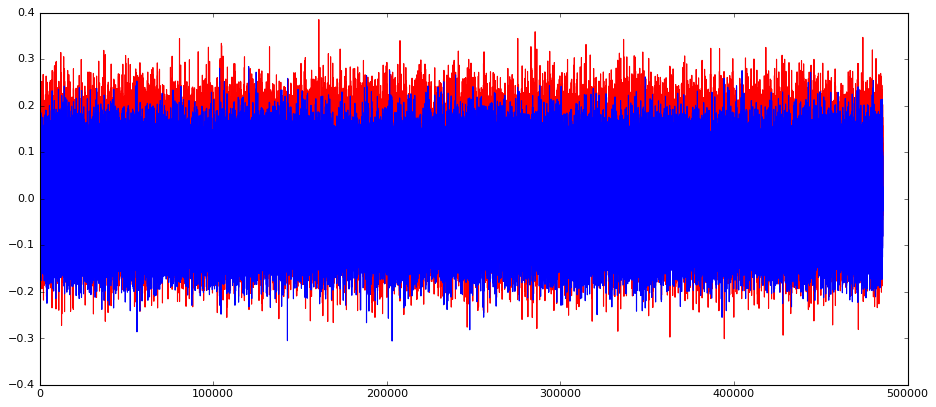

In [27]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_sample)
ax.plot(range(0,size), healthy_sample[:,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_sample[:,1], '-', color='blue', animated = True, linewidth=1)

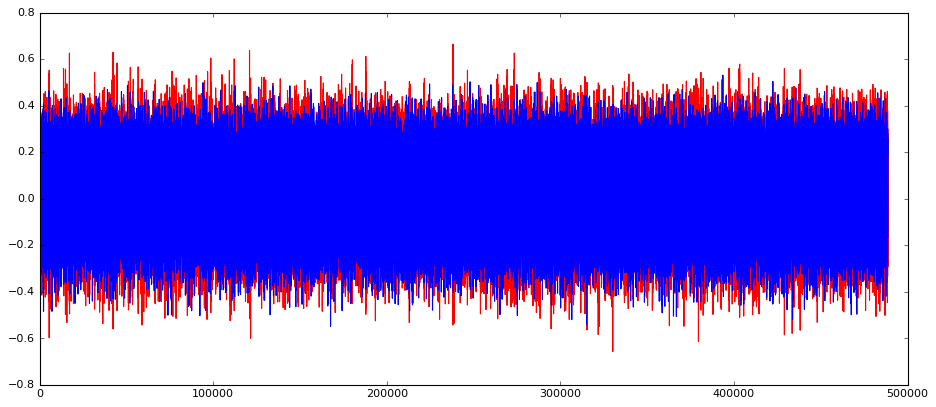

In [28]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_sample)
ax.plot(range(0,size), faulty_sample[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), faulty_sample[:,0], '-', color='blue', animated = True, linewidth=1)

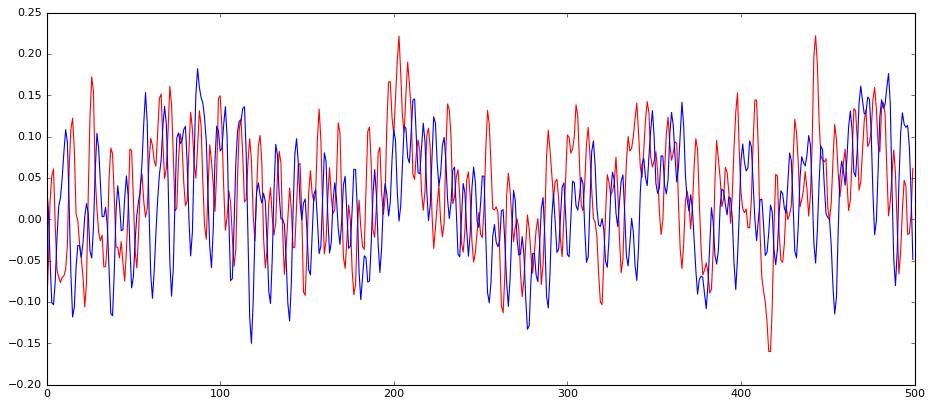

In [36]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), healthy_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), healthy_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

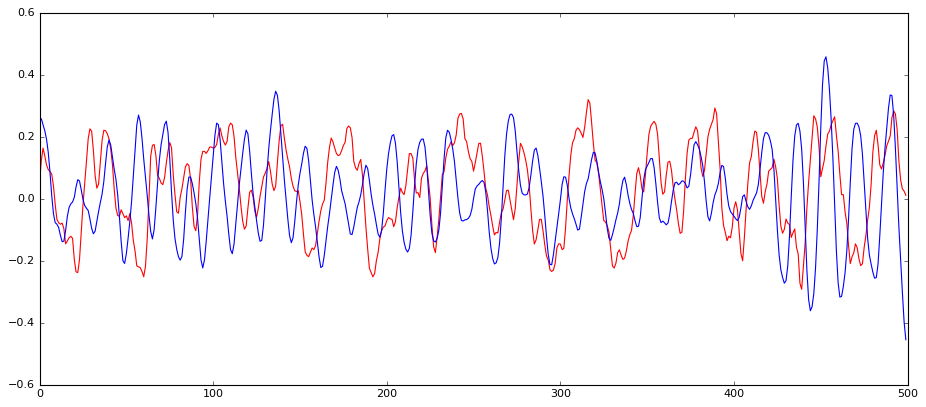

In [35]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), faulty_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), faulty_sample[:500,1], '-', color='blue', animated = True, linewidth=1)

In [16]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [17]:
timesteps = 100
dim = 2
lossHistory = LossHistory()
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    model.fit(data, data, epochs=20, batch_size=72, validation_data=(data, data), verbose=0, shuffle=False,callbacks=[lossHistory])

def score(data):
    yhat =  model.predict(data)
    return yhat

In [18]:
def create_trimmed_recording(df,file_id):
    recording = np.array(df.orderBy(df['_c0']).where(df['_c1'] == file_id).select('_c2','_c3').rdd.map(lambda row: np.array([row._c2,row._c3])).collect())  
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (samples/timesteps,timesteps,dim)
    return recording_trimmed

In [19]:
file_ids = spark.sql('select distinct _c1 from df_healthy').rdd.map(lambda row : row._c1).collect()
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy,file_id)
    print "Staring training on %s" % (file_id)
    train(recording_trimmed)
    print "Finished training on %s after %s seconds" % (file_id,time.time()-start)

print "Finished job on after %s seconds" % (time.time()-start)
healthy_losses = lossHistory.losses


Staring training on 98
Finished training on 98 after 244.075187922 seconds
Staring training on 100
Finished training on 100 after 477.574754 seconds
Staring training on 97
Finished training on 97 after 646.223609924 seconds
Finished job on after 646.224179029 seconds


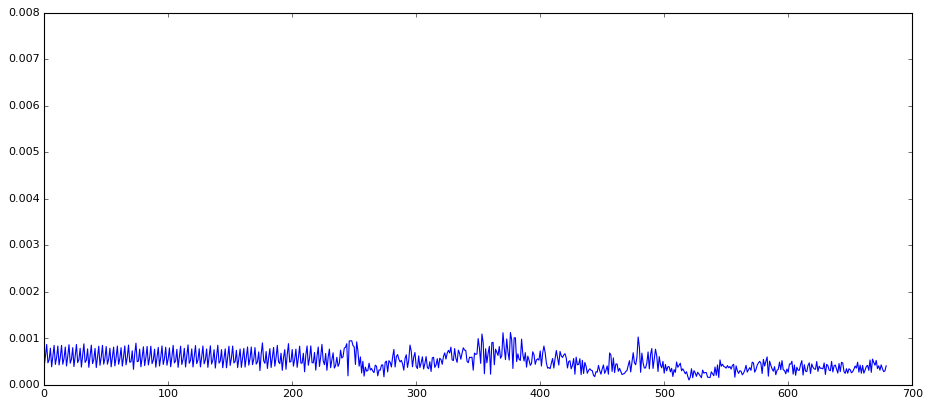

In [20]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

In [21]:
#file_ids = spark.sql('select distinct _c1 from df_healhty').rdd.map(lambda row : row._c1).collect()
start = time.time()
for file_id in [105]:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print "Staring training on %s" % (file_id)
    train(recording_trimmed)
    print "Finished training on %s after %s seconds" % (file_id,time.time()-start)

print "Finished job on after %s seconds" % (time.time()-start)
faulty_losses = lossHistory.losses

Staring training on 105
Finished training on 105 after 92.8888118267 seconds
Finished job on after 92.8902578354 seconds


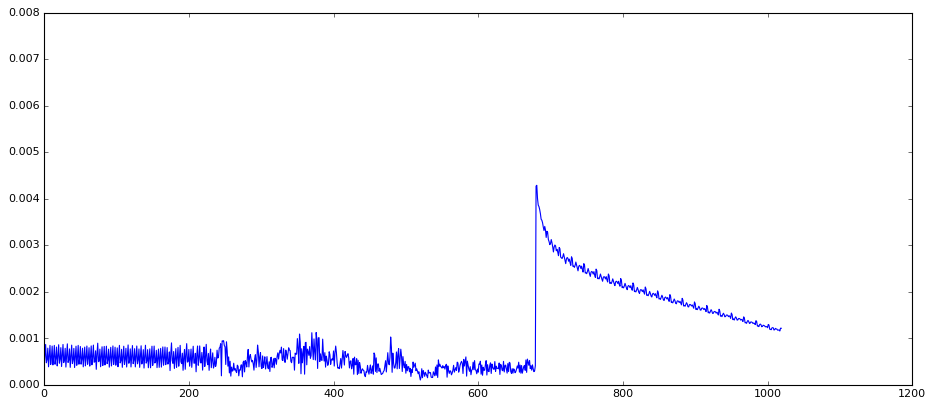

In [22]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses+faulty_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses+faulty_losses, '-', color='blue', animated = True, linewidth=1)